In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import HeatMap

In [21]:
df1 = pd.read_csv(r'C:\Users\Johannes\Documents\Uni\Master\Tech_Labs\ws24-skillswap\DS\01_Notebooks\02_Features_Insights\01_User_Activity_Status\Skillswap_Data_Activity_Status.csv')
pd.set_option('display.max_columns', None)

df1.head()

,First_Name,EMail,Age,Gender,Location_Preferences,Latitude,Longitude,Country,City,Languages_Preferred,Last_Seen,Response_Time,Farming_off,Fishery_off,Gardening_off,Pet grooming_off,Pet training_off,Drawing_off,Painting_off,Sculpture_off,Print making_off,Poetry_off,Make-up_off,Facials_off,Pedicure & Manicure_off,Hair care_off,Ballet_off,Tap dance_off,Jazz dance_off,Salsa_off,Ballroom dance_off,Piano_off,Guitar_off,Drumming_off,Trumpet_off,Composing_off,Script writing_off,Play writing_off,Poetry writing_off,Caligraphy_off,Blogging_off,Journalism_off,German_off,Spanish_off,Arabic_off,French_off,English_off,Nutrition_off,Fitness & Excercise_off,Wellness_off,Tennis_off,Football_off,Basketball_off,Yoga_off,Baseball_off,Gymnastic_off,Cooking_off,Baking_off,Grilling_off,Meal planning_off,Sautéing_off,Programming_off,Graphic design_off,Data Analysis_off,Photoshop_off,Social Media_off,Camera handling_off,Photo editing_off,Lighting_off,Landscape photography_off,Portrait photography_off,Image processing_off,Video editing_off,Film making_off,Animation_off,Motion graphics_off,Visual effects_off,Skill Domains,Farming_dem,Fishery_dem,Gardening_dem,Pet grooming_dem,Pet training_dem,Drawing_dem,Painting_dem,Sculpture_dem,Print making_dem,Poetry_dem,Make-up_dem,Facials_dem,Pedicure & Manicure_dem,Hair care_dem,Ballet_dem,Tap dance_dem,Jazz dance_dem,Salsa_dem,Ballroom dance_dem,Piano_dem,Guitar_dem,Drumming_dem,Trumpet_dem,Composing_dem,Script writing_dem,Play writing_dem,Poetry writing_dem,Caligraphy_dem,Blogging_dem,Journalism_dem,German_dem,Spanish_dem,Arabic_dem,French_dem,English_dem,Nutrition_dem,Fitness & Excercise_dem,Wellness_dem,Tennis_dem,Football_dem,Basketball_dem,Yoga_dem,Baseball_dem,Gymnastic_dem,Cooking_dem,Baking_dem,Grilling_dem,Meal planning_dem,Sautéing_dem,Programming_dem,Graphic design_dem,Data Analysis_dem,Photoshop_dem,Social Media_dem,Camera handling_dem,Photo editing_dem,Lighting_dem,Landscape photography_dem,Portrait photography_dem,Image processing_dem,Video editing_dem,Film making_dem,Animation_dem,Motion graphics_dem,Visual effects_dem,Count_Farming_off,Count_Fishery_off,Count_Gardening_off,Count_Pet_grooming_off,Count_Pet_training_off,Count_Drawing_off,Count_Painting_off,Count_Sculpture_off,Count_Print_making_off,Count_Poetry_off,Count_Make_up_off,Count_Facials_off,Count_Pedicure_and_Manicure_off,Count_Hair_care_off,Count_Ballet_off,Count_Tap_dance_off,Count_Jazz_dance_off,Count_Salsa_off,Count_Ballroom_dance_off,Count_Piano_off,Count_Guitar_off,Count_Drumming_off,Count_Trumpet_off,Count_Composing_off,Count_Script_writing_off,Count_Play_writing_off,Count_Poetry_writing_off,Count_Caligraphy_off,Count_Blogging_off,Count_Journalism_off,Count_German_off,Count_Spanish_off,Count_Arabic_off,Count_French_off,Count_English_off,Count_Nutrition_off,Count_Fitness_and_Excercise_off,Count_Wellness_off,Count_Tennis_off,Count_Football_off,Count_Basketball_off,Count_Yoga_off,Count_Baseball_off,Count_Gymnastic_off,Count_Cooking_off,Count_Baking_off,Count_Grilling_off,Count_Meal_planning_off,Count_Sautéing_off,Count_Programming_off,Count_Graphic_design_off,Count_Data_Analysis_off,Count_Photoshop_off,Count_Social_Media_off,Count_Camera_handling_off,Count_Photo_editing_off,Count_Lighting_off,Count_Landscape_photography_off,Count_Portrait_photography_off,Count_Image_processing_off,Count_Video_editing_off,Count_Film_making_off,Count_Animation_off,Count_Motion_graphics_off,Count_Visual_effects_off,Count_Social Media_off,Count_Make-up_off,Count_Video editing_off,Count_Film making_off,Count_Pedicure & Manicure_off,Count_Pet training_off,Count_Pet grooming_off,Count_Graphic design_off,Count_Image processing_off,Count_Fitness & Excercise_off,Count_Visual effects_off,Count_Camera handling_off,Count_Print making_off,Count_Hair care_off,Count_Play writing_off,Count_Portrait photography_off,Count_Data Analysis_off,Count_Tap dance_off,Count_Photo editing_off,Count_Meal planning_off,Count_Landscape photography_off,Count_Jazz dance_off,Count_Ballro

# Goal: Get the 10 closest "Super Swaps": Matches where both parties can serve serve each other's interests

# 1. Select a random user

In [22]:
# Select Random User and show the skill portfolio and the skill interests
random_row = df1.sample()

selected_columns = random_row[['First_Name', 'Latitude', 'Longitude', 'Location_Preferences', 'Activity_Status']]

off_columns = [col for col in df1.columns if col.endswith('_off') and not pd.isna(random_row[col].values[0])]
selected_off_columns = random_row[off_columns]
columns_to_drop = [col for col in selected_off_columns.columns if col.startswith("Count_")]
selected_off_columns.drop(columns=columns_to_drop, inplace=True)

dem_columns = [col for col in df1.columns if col.endswith('_dem') and random_row[col].values[0] != 0]
selected_dem_columns = random_row[dem_columns]

df2 = pd.concat([selected_columns, selected_off_columns, selected_dem_columns], axis=1)
df2

C:\Users\Johannes\AppData\Local\Temp\ipykernel_11528\3160578494.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_off_columns.drop(columns=columns_to_drop, inplace=True)


,First_Name,Latitude,Longitude,Location_Preferences,Activity_Status,Ballet_off,Tap dance_off,Jazz dance_off,Salsa_off,Ballroom dance_off,Piano_off,Guitar_off,Drumming_off,Trumpet_off,Composing_off,Farming_dem,Fishery_dem,Gardening_dem,Pet grooming_dem,Pet training_dem,Piano_dem,Guitar_dem,Drumming_dem,Trumpet_dem,Composing_dem,German_dem,Spanish_dem,Arabic_dem,French_dem,English_dem,Cooking_dem,Baking_dem,Grilling_dem,Meal planning_dem,Sautéing_dem
7,Valeria,52.36655,13.608009,Local or Remote,Active User,Novice,Beginner,Advanced,Expert,Expert,Intermediate,Intermediate,Beginner,Advanced,Novice,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# 2. Find the right matches for the random user

## 2.1. Find the other users that offer skills the random user is interested in

In [23]:

# Step 1: Take the columns from df2 that end with "_dem"
df2_columns = [col for col in df2.columns if col.endswith('_dem')]

# Step 2: Replace the "_dem" with "_off"
df2_columns_off = [col.replace('_dem', '_off') for col in df2_columns]

# Step 3: Check if there are columns in the DataFrame df1 that match the names of the columns from step 2
matching_columns = [col for col in df1.columns if col in df2_columns_off]

# Step 4: Create a new DataFrame showing all rows where at least one of these columns has a value that is not NaN and exclude the row with the index of the rows in df2
selected_rows = df1[df1[matching_columns].notnull().any(axis=1) & ~df1.index.isin(df2.index)]


## 2.2 From the skill columns display only the columns that match the random user's interests and the random user's skill portfolio (indicating which skills the random user offers)

In [24]:
# Select the required columns
selected_columns = ['First_Name', 'Latitude', 'Longitude', 'Location_Preferences', 'Activity_Status']

# Select columns ending with "_off" and not NaN
selected_off_columns = [col for col in selected_rows.columns if col.endswith('_off') and col in df2_columns_off and not selected_rows[col].isna().all()]

# Select columns ending with "_dem" and not "0" and match the offering of the random user
selected_rows_columns = [col for col in df2.columns if col.endswith('_off')]
selected_rows_columns_dem = [col.replace('_off', '_dem') for col in selected_rows_columns]

selected_dem_columns = [col for col in selected_rows.columns if col.endswith('_dem') and col in selected_rows_columns_dem and (selected_rows[col] != 0).any()]

# Add the selected columns to the list
selected_columns.extend(selected_off_columns)
selected_columns.extend(selected_dem_columns)

# Extract the required DataFrame with selected columns
potential_matches = selected_rows[selected_columns]
potential_matches.head()

,First_Name,Latitude,Longitude,Location_Preferences,Activity_Status,Farming_off,Fishery_off,Gardening_off,Pet grooming_off,Pet training_off,Piano_off,Guitar_off,Drumming_off,Trumpet_off,Composing_off,German_off,Spanish_off,Arabic_off,French_off,English_off,Cooking_off,Baking_off,Grilling_off,Meal planning_off,Sautéing_off,Ballet_dem,Tap dance_dem,Jazz dance_dem,Salsa_dem,Ballroom dance_dem,Piano_dem,Guitar_dem,Drumming_dem,Trumpet_dem,Composing_dem
0,Tymon,52.425343,13.695938,Local or Remote,Swapper,Expert,Intermediate,Expert,Novice,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,1,1,1
2,Eryk,52.651681,13.713052,Local or Remote,Swapper,Beginner,Intermediate,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,1,1,1
3,Graeme,52.459891,13.192676,Local or Remote,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Novice,Beginner,Expert,Beginner,Expert,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
5,Gerald,52.649837,13.291504,Local or Remote,Occasional User,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Advanced,Novice,Expert,Beginner,Novice,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
10,Lilia,52.354862,13.206430,Local Only,Occasional User,NaN,NaN,NaN,NaN,NaN,Novice,Novice,Expert,Beginner,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,0,0,0,0,0


## 2.3 Filter for the other users that are also interested in the skills the random user offers

In [25]:
Perfect_Matches = pd.DataFrame()

perfect_matches_rows = []

potential_matches_columns = [col for col in potential_matches.columns if col.endswith('_dem')]

for index, row in potential_matches.iterrows():
    if not all(row[col] == 0 for col in potential_matches_columns):
        row['OG_Index'] = index
        perfect_matches_rows.append(row)

Perfect_Matches = pd.DataFrame(perfect_matches_rows)

cols = Perfect_Matches.columns.tolist()
cols = ['OG_Index'] + [col for col in cols if col != 'OG_Index']
Perfect_Matches = Perfect_Matches[cols]

Perfect_Matches.reset_index(drop=True, inplace=True)
Perfect_Matches


,OG_Index,First_Name,Latitude,Longitude,Location_Preferences,Activity_Status,Farming_off,Fishery_off,Gardening_off,Pet grooming_off,Pet training_off,Piano_off,Guitar_off,Drumming_off,Trumpet_off,Composing_off,German_off,Spanish_off,Arabic_off,French_off,English_off,Cooking_off,Baking_off,Grilling_off,Meal planning_off,Sautéing_off,Ballet_dem,Tap dance_dem,Jazz dance_dem,Salsa_dem,Ballroom dance_dem,Piano_dem,Guitar_dem,Drumming_dem,Trumpet_dem,Composing_dem
0,0,Tymon,52.425343,13.695938,Local or Remote,Swapper,Expert,Intermediate,Expert,Novice,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,1,1,1
1,2,Eryk,52.651681,13.713052,Local or Remote,Swapper,Beginner,Intermediate,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,1,1,1
2,10,Lilia,52.354862,13.206430,Local Only,Occasional User,NaN,NaN,NaN,NaN,NaN,Novice,Novice,Expert,Beginner,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,0,0,0,0,0
3,11,Pierre,52.533408,13.197651,Remote Only,Occasional User,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expert,Novice,Advanced,Intermediate,Expert,1,1,1,1,1,0,0,0,0,0
4,16,Mattias,52.600496,13.215151,Local Only,Active User,NaN,NaN,NaN,NaN,NaN,Intermediate,Beginner,Novice,Expert,Novice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,785,Margita,52.593465,13.692746,Local or Remote,Active User,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Novice,Intermediate,Beginner,Advanced,Intermediate,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,0,0,0,0,0
159,787,Jade,52.416991,13.319112,Remote Only,Inactive,NaN,NaN,NaN,Novice,Expert,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,1,1,1
160,788,Annibale,52.575093,13.614960,Remote Only,Active User,NaN,NaN,NaN,NaN,NaN,Intermediate,Expert,Novice,Beginner,Novice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,1,1,1
161,791,Oreste,52.416943,13.448605,Local or Remote,Occasional User,NaN,NaN,NaN,NaN,NaN,Novice,Intermediate,Novice,Expert,Expert,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,0,0,0,0,0


## 2.4 Get rid of inactive users & users that are not available for in-person meetings 

In [26]:
Perfect_Matches_filtered = Perfect_Matches[(Perfect_Matches['Activity_Status'] != 'Inactive') & (Perfect_Matches['Location_Preferences'] != 'Remote Only')]
Perfect_Matches_filtered.head()

,OG_Index,First_Name,Latitude,Longitude,Location_Preferences,Activity_Status,Farming_off,Fishery_off,Gardening_off,Pet grooming_off,Pet training_off,Piano_off,Guitar_off,Drumming_off,Trumpet_off,Composing_off,German_off,Spanish_off,Arabic_off,French_off,English_off,Cooking_off,Baking_off,Grilling_off,Meal planning_off,Sautéing_off,Ballet_dem,Tap dance_dem,Jazz dance_dem,Salsa_dem,Ballroom dance_dem,Piano_dem,Guitar_dem,Drumming_dem,Trumpet_dem,Composing_dem
0,0,Tymon,52.425343,13.695938,Local or Remote,Swapper,Expert,Intermediate,Expert,Novice,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,1,1,1
1,2,Eryk,52.651681,13.713052,Local or Remote,Swapper,Beginner,Intermediate,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,1,1,1
2,10,Lilia,52.354862,13.206430,Local Only,Occasional User,NaN,NaN,NaN,NaN,NaN,Novice,Novice,Expert,Beginner,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,0,0,0,0,0
4,16,Mattias,52.600496,13.215151,Local Only,Active User,NaN,NaN,NaN,NaN,NaN,Intermediate,Beginner,Novice,Expert,Novice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,1,1,1
6,32,Aniela,52.614361,13.546320,Local or Remote,Occasional User,NaN,NaN,NaN,NaN,NaN,Expert,Advanced,Intermediate,Novice,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,0,0,0,0,0


# 3. Plot the locations of users that would make Super Swaps

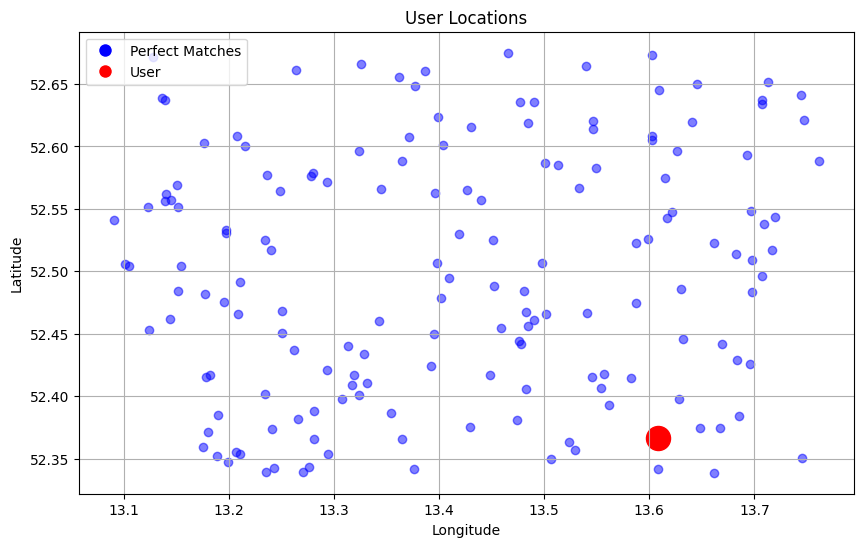

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(Perfect_Matches['Longitude'], Perfect_Matches['Latitude'], color='blue', alpha=0.5, label='Perfect Matches')

plt.scatter(df2['Longitude'], df2['Latitude'], color='red', alpha=1, label='User', s=300)

plt.title('User Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(scatterpoints=1)
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='blue'),
                  plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red')]
plt.legend(legend_handles, ['Perfect Matches', 'User'])
plt.grid(True)
plt.show()


# 4. Get 10 closest Super Swaps & visualize their locations

In [28]:
# Create one concatenated dataframe 
Match_Coordinates = Perfect_Matches_filtered.drop(columns=['OG_Index'])

concatenated_df = pd.concat([df2, Match_Coordinates])
concatenated_df.reset_index(drop=True, inplace=True)
concatenated_df.head()

,First_Name,Latitude,Longitude,Location_Preferences,Activity_Status,Ballet_off,Tap dance_off,Jazz dance_off,Salsa_off,Ballroom dance_off,Piano_off,Guitar_off,Drumming_off,Trumpet_off,Composing_off,Farming_dem,Fishery_dem,Gardening_dem,Pet grooming_dem,Pet training_dem,Piano_dem,Guitar_dem,Drumming_dem,Trumpet_dem,Composing_dem,German_dem,Spanish_dem,Arabic_dem,French_dem,English_dem,Cooking_dem,Baking_dem,Grilling_dem,Meal planning_dem,Sautéing_dem,Farming_off,Fishery_off,Gardening_off,Pet grooming_off,Pet training_off,German_off,Spanish_off,Arabic_off,French_off,English_off,Cooking_off,Baking_off,Grilling_off,Meal planning_off,Sautéing_off,Ballet_dem,Tap dance_dem,Jazz dance_dem,Salsa_dem,Ballroom dance_dem
0,Valeria,52.366550,13.608009,Local or Remote,Active User,Novice,Beginner,Advanced,Expert,Expert,Intermediate,Intermediate,Beginner,Advanced,Novice,1.0,1.0,1.0,1.0,1.0,1,1,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tymon,52.425343,13.695938,Local or Remote,Swapper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expert,Intermediate,Expert,Novice,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2,Eryk,52.651681,13.713052,Local or Remote,Swapper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,Intermediate,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
3,Lilia,52.354862,13.206430,Local Only,Occasional User,NaN,NaN,NaN,NaN,NaN,Novice,Novice,Expert,Beginner,Beginner,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
4,Mattias,52.600496,13.215151,Local Only,Active User,NaN,NaN,NaN,NaN,NaN,Intermediate,Beginner,Novice,Expert,Novice,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [29]:
# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# Take the first row of concatenated_df and extract the Latitude and Longitude
target_coordinate = concatenated_df[['Latitude', 'Longitude']].iloc[0]

# Calculate Euclidean distance for all rows in concatenated_df except the first row
distances = []
for index, row in concatenated_df.iloc[1:].iterrows():
    distance = euclidean_distance(row[['Latitude', 'Longitude']], target_coordinate)
    distances.append((index, distance))

# Sort distances
distances.sort(key=lambda x: x[1])

# Get the indices of the closest 10 points
closest_indices = [index for index, _ in distances[:10]]

# Extract the closest coordinates
closest_coordinates = concatenated_df.loc[closest_indices, ['Latitude', 'Longitude']]

# Step 1: Get the indices of closest_coordinates
# Step 2: Use the indices to locate the respective rows in concatenated_df
# Step 3: Extract the desired columns
# Step 4: Create a new DataFrame with the selected rows

closest_indices = closest_coordinates.index
selected_rows = concatenated_df.loc[closest_indices]
selected_rows_subset = selected_rows.iloc[:, :4]


selected_rows_subset

,First_Name,Latitude,Longitude,Location_Preferences
45,Giulia,52.398020,13.628053,Local or Remote
19,Wojciech,52.374689,13.648609,Local Only
60,Mohammad,52.414526,13.583058,Local or Remote
13,Graeme,52.374457,13.667034,Local or Remote
20,Julian,52.338629,13.661687,Local or Remote
55,Rossana,52.406283,13.554482,Local or Remote
33,Stefania,52.384343,13.685306,Local or Remote
27,Victoire,52.445718,13.632201,Local or Remote
92,Raffaele,52.441353,13.669451,Local or Remote
71,Romeo,52.428938,13.683899,Local or Remote


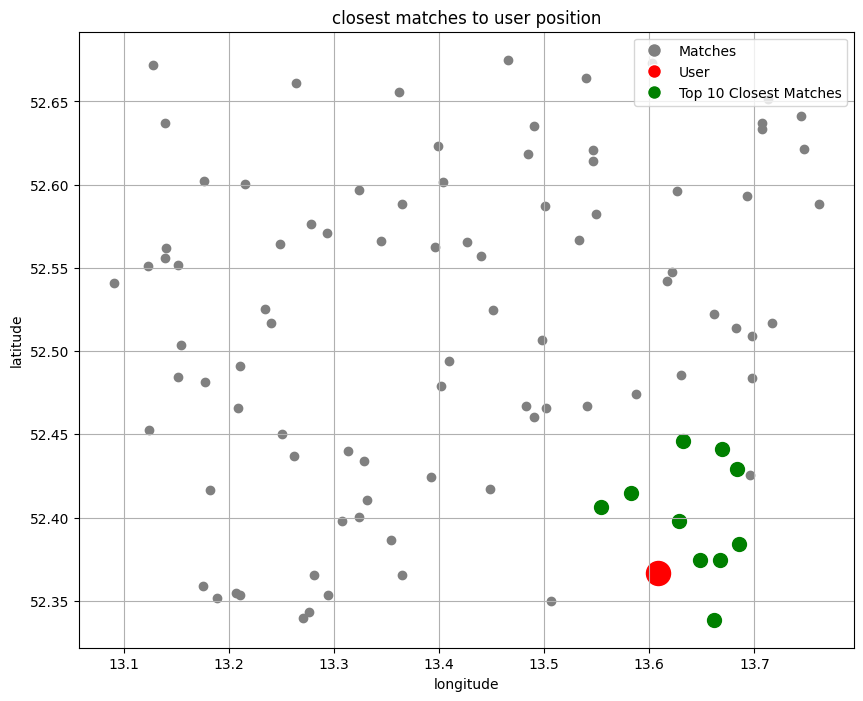

In [30]:
plt.figure(figsize=(10, 8))

plt.scatter(concatenated_df['Longitude'], concatenated_df['Latitude'], color='grey', label='All Data Points')

plt.scatter(target_coordinate['Longitude'], target_coordinate['Latitude'], color='red', label='Target Coordinate', s=300)

plt.scatter(closest_coordinates['Longitude'], closest_coordinates['Latitude'], color='green', label='Closest Points', s=100)

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('closest matches to user position')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='grey'),
                  plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red'),
                  plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='green')]
plt.legend(legend_handles, ['Matches', 'User', 'Top 10 Closest Matches'])

plt.grid(True)

plt.show()


In [31]:
# Visualise top 10 matches on the real map of Berlin (click)

# Create a base map centered around Berlin
berlin_map = folium.Map(location=[52.52, 13.405], zoom_start=12)

data_points = list(zip(concatenated_df['Latitude'], concatenated_df['Longitude']))

HeatMap(data_points).add_to(berlin_map)

folium.Marker(location=[target_coordinate['Latitude'], target_coordinate['Longitude']], popup='Your Position', icon=folium.Icon(color='red')).add_to(berlin_map)
for index, row in selected_rows_subset.iterrows():
    folium.Marker(location=[row['Latitude'], row['Longitude']], popup=f'{row["First_Name"]}', icon=folium.Icon(color='green')).add_to(berlin_map)

berlin_map